# Lab Course: Distributed Data Analytics Exercise Sheet 4
**Submitted by: Mohit Bansal**

**Student ID: 279314**

### Distributed Machine Learning (Supervised) (10 Points)

In this exercise sheet you are going to implement a supervised machine learning algorithm in a distributed setting using MPI (mpi4py). We will pick a simple Linear Regression model and train it using a parallel stochastic gradient algorithm (PSGD).

### 1. Parallel Linear Regression 

The first task in this exercise is to implement a linear regression model and learn it using PSGD learning algorithm explained above. You will implement it using mpi4py. A basic version of PSGD could be though of using one worker as a Master, whose sole responsibility is getting local models from other workers and averaging the model. A slight modification could be though of using all the workers as worker and no separate master worker. [Hint: Think of collective routines that can help you in averaging the models and return the result on each worker]. Once you implement your model, show that your implementation can work for any number of workers i.e. P = {2, 4, 6, 8}.

### Dataset

I have used the following dataset, <a href = https://archive.ics.uci.edu/ml/datasets/Dynamic+Features+of+VirusShare+Executables> DynamicFeaturesofVirusShareExecutablesDataSet </a>


### Libraries

We will primarily use:

* sklearn library for regression
* pandas, numpy for data wrangling
* mpi4py for parallelization

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu May 10 12:08:11 2018

@author: mundanemohit
"""

import sklearn  
from sklearn.datasets import load_svmlight_file
import pandas as pd
import os
import numpy as np
from mpi4py import MPI                      # Load MPI Library
from sklearn.metrics import mean_squared_error
from decimal import Decimal, ROUND_HALF_UP
import random

### Step 1: Loading Data

Data is loaded using 'load_svmlight_file' function which outputs x components and the dependent y component seperately. Since there are multiple files, we use a loop to append data

In [ ]:
def loadData():
    x_df = []
    y_df = []
    path = '/Users/mundanemohit/Google Drive/My Work/MSc. Data Analytics/3114 Distributed Data Analytics/Excercises/Ex04/dataset/'
    files= os.listdir(path)
    os.chdir(path)
    # Read data
    for file in files:  
        x, y = load_svmlight_file(file)
        x_df.append(pd.DataFrame(x.todense()))
        y_df.append(y)
    x_df = pd.concat(x_df).fillna(0)
    x_df = pd.DataFrame(sklearn.preprocessing.normalize(x_df))
    y_df = pd.DataFrame(np.concatenate(np.array(y_df)))

    return x_df, y_df

### Step 2: Data Slicing

training set (x, y) is sliced based on number of processors

In [ ]:
def chunkData(x_df_train, y_df_train, size):
    # Slices
    slice = int(Decimal(x_df_train.shape[0]/size).quantize(Decimal('1.'), rounding = ROUND_HALF_UP))      
    print('Slice size: {}'.format(slice))
    x_slice_train = []
    y_slice_train = []
    for i in range(0,size):
        if i < size - 1:
            x_slice_train.append(x_df_train[slice*i:slice*(i+1)])
            y_slice_train.append(y_df_train[slice*i:slice*(i+1)])
        else:
            x_slice_train.append(x_df_train[slice*i:])
            y_slice_train.append(y_df_train[slice*i:])
    return x_slice_train, y_slice_train

### Step 3: Predict y-hat

Using the coefficients, y is predicted on the given dataset

In [ ]:
def predictY(data, coef):
      result = np.zeros(data.shape[0])
      for j in range(0, data.shape[1]):
           result += data[j]*coef[j]
      return pd.DataFrame(result)    

### Step 4: Recalculate weights (S.G.D.)

Using stochastic gradient descent, weights are recalculated based on learning rate, error and sample size.

In [ ]:
def recalibrateWeight(X, Y, pred_Y, coef, rate, sample = 1000):
   for i in random.sample(range(0, X.shape[0]), sample):
        error = (pred_Y.iloc[i] - Y.iloc[i])
        for j in range(0, X.shape[1]):
            coef[j] = (coef[j] - (rate * error * X.iloc[i][j]))
   return coef

### Step 5: Main function

* Root loads data
* Root creates 70-30 train and test sets randomly
* Root slices the training set and scatters to workers
* Root calculates base error on testing set for benchmarking
* For each epoch:
    * Predict y-hat
    * Update coefficients
    * Root node averages the coefficients
    * Root recalculates error on test set
* Final error is calculated on test set

In [ ]:
comm = MPI.COMM_WORLD                       # Initialize communicator
rank=comm.Get_rank()                        # Current worker
status = MPI.Status()                       # Rank ID of sender
root = 0                                    # Setup root node
epochs = 10                                 # Set number of epochs

if rank == root:
    size = comm.Get_size()
    print('No. of workers: {}' .format(size))
    
    # Read data
    x_df, y_df = loadData()

    # Split the targets into training/testing sets
    msk = np.random.rand(len(x_df)) <= 0.7
    x_df_train = x_df[msk]
    y_df_train = y_df[msk]
    x_df_test  = x_df[~msk]
    y_df_test  = y_df[~msk]
    
    # Create slices for scattering
    x_slice_train, y_slice_train = chunkData(x_df_train, y_df_train, size)
    
    # Predict initial error for benchmarking
    coef = np.zeros(x_df_train.shape[1])
    predicted_y = predictY(x_df_test, np.zeros(x_df_train.shape[1]))
    print("Initial Error: ", mean_squared_error(y_df_test, predicted_y))
else:
    x_slice_train = None
    y_slice_train = None

wt = MPI.Wtime()

# Sending slices to workers   
x_slice_train = comm.scatter(x_slice_train, root = root)
y_slice_train = comm.scatter(y_slice_train, root = root)

# Set coefficients to zero for initial run
coef = np.zeros(x_slice_train.shape[1])

for e in range(0, epochs):
    predicted_y = predictY(x_slice_train, coef)
    # Calculate New coeffs
    coef =  recalibrateWeight(x_slice_train, y_slice_train, predicted_y, coef, rate = 0.001, sample = 50)
    # Gather coefficients
    gathData = pd.DataFrame(comm.gather(coef, root=0))
    comm.barrier()
    if rank == root:
        coef = gathData.mean()
        predicted_y = predictY(x_df_test, coef)    
        print("EPOCH: {}, Error: {}" .format(e, mean_squared_error(y_df_test, predicted_y)))
    print('Process {}: {} secs.' .format(rank, MPI.Wtime() - wt))

### 2. Performance and convergence of PSGD (10 points)

The second task is to do some performance analysis and convergence tests.

1. First, you have to check the convergence behavior of your model learned through PSGD and compare it to a sequential version. You will plot the convergence curve (Train/Test score verses the number of epochs) for P = {1, 2, 4, 6, 7}. 

2. Second, you have to do a performance analysis by plotting learning curve (Train/Test scores) verses time. Time your program for P = {1, 2, 4, 6, 7}.

### Solution:

Below plot shows convergence behaviour for number of epochs for P = {1, 2, 4, 6, 7}.

**Learning rate = 0.001**
**Sample Size = 50**

Sample size is kept small since the process takes a long time to run for bigger samples.

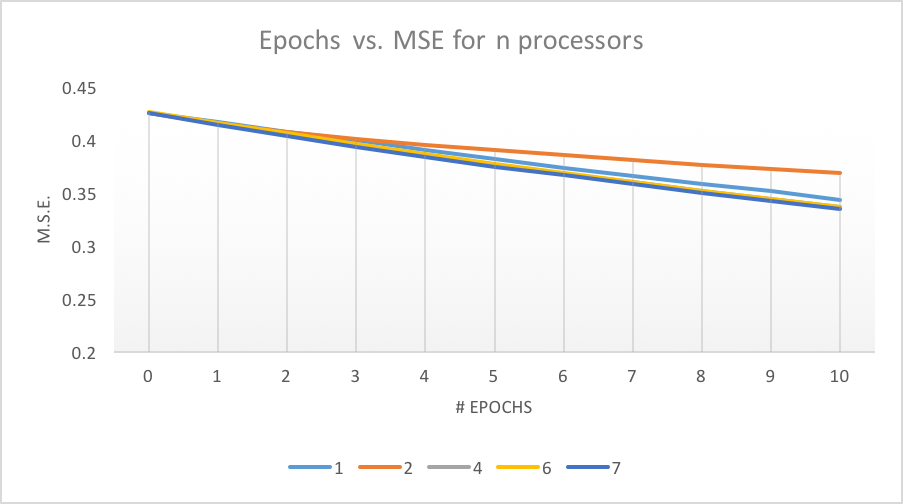

It looks like when # Processors > 2, the algorithm outperformed itself. 

One reason is that since we're not training on the whole dataset, more processors mean more samples. i.e.

1 Process = 50 samples
2 Processes = 100 samples

and so on...

Another reason is that we're averaging the coefficients from all processors. This means that rather than converging on 1 minima, multiple minimas are calculated parallely and average is taken. This is analogous to random forest method in decision trees which is known to outperfrom recursive trees.

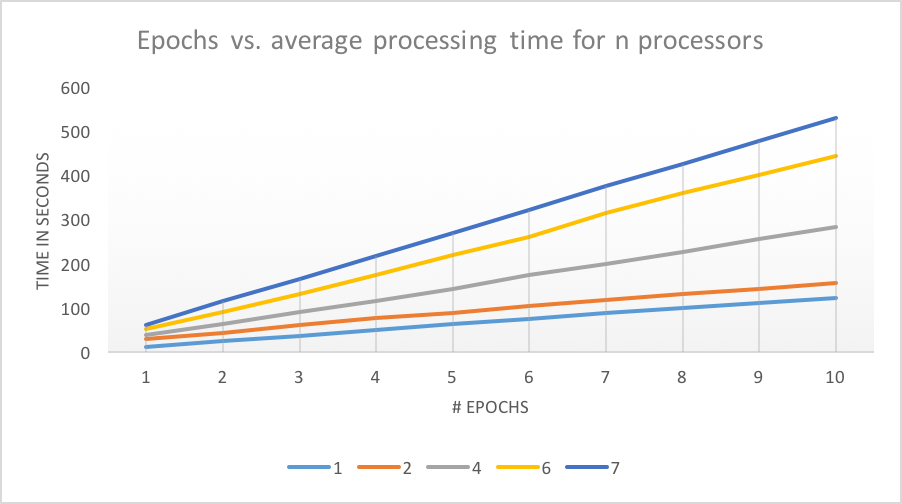



It seems that the average processing time for each process also increases with the increase in number of workers. However, these results could be misleading as we're actually working on single processors systems and true optimization may not be achieved.

But the processing time could also be increasing due to waiting time during communication. Workers are waiting to recieve coefficients from master. However, master node becomes more and more busy as the no. of processes increase.